# Creating baseline performance for MPI


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#import hvplot.xarray
import sys

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-10-20 12:07:47.311010: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-10-20 12:07:47.311400: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
mpi_data_path = "../../data/mpi_001"

dist_map = pd.read_csv("../../src/dist_map.csv",header=None).to_numpy()
dist_map = np.roll(np.fliplr(dist_map),180)
dist_map = np.repeat(dist_map[np.newaxis, :, : ], 421, axis=0)

def read_xarray_mpi(dir_name="",num="006"):
    '''
     read_xarray(dir)name) opens data and returns data in xarray format for each feature
    '''
    date="198201-201701"
  
    file_type ="MPI"
        
    chl = xr.open_dataset(f'{dir_name}/Chl_2D_mon_{file_type}{num}_1x1_{date}.nc')

    mld = xr.open_dataset(f'{dir_name}/MLD_2D_mon_{file_type}{num}_1x1_{date}.nc')

    sss = xr.open_dataset(f'{dir_name}/SSS_2D_mon_{file_type}{num}_1x1_{date}.nc')

    sst = xr.open_dataset(f'{dir_name}/SST_2D_mon_{file_type}{num}_1x1_{date}.nc')

    xco2 = xr.open_dataset(f'../../data/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc')

    pco2 = xr.open_dataset(f'{dir_name}/pCO2_2D_mon_{file_type}{num}_1x1_{date}.nc')

    return chl,mld,sss,sst,xco2,pco2


chl,mld,sss,sst,xco2,pco2 = read_xarray_mpi(mpi_data_path)
xco2['time'] = xco2.indexes['time'].to_datetimeindex().strftime("%Y-%m")

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/tmp/ipykernel_1165224/479448007.py:31: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  xco2['time'] = xco2.indexes['time'].to_datetimeindex().strftime("%Y-%m")


In [3]:
xco2_df = pd.DataFrame()
xco2_df["XCO2"] = xco2.XCO2
xco2_df.index = xco2.time

data_read=xr.merge([mld.MLD,mld.MLD_socat,chl.Chl,chl.Chl_socat,sst.SST,sst.SST_socat,sss.SSS,sss.SSS_socat])

tmp_data=data_read.to_dataframe().reset_index()
tmp_data["time"] = tmp_data["time"].dt.strftime("%Y-%m")

In [4]:
later_df = tmp_data
later_df = later_df.set_index(['time','ylat','xlon'])
pco2_data = pco2.pCO2.to_dataframe()
pco2_data_socat = pco2.pCO2_socat.to_dataframe()
later_df["pCO2_socat"]=pco2_data_socat["pCO2_socat"]
later_df["pCO2"]=pco2_data["pCO2"]

In [5]:
tmp_data = xco2_df.join(tmp_data.set_index('time'),how = "right")
tmp_data.dropna(subset = ["XCO2"], inplace=True)
tmp_data = tmp_data.reset_index()

In [6]:
tmp_data.columns = ["time",'XCO2','xlon', 'ylat','MLD','MLD_socat','Chl','Chl_socat','SST','SST_socat','SSS','SSS_socat']

In [7]:
tmp_data.dropna(subset = ["Chl"], inplace=True)

In [8]:
pco2_data = pco2.pCO2.to_dataframe().reset_index()
pco2_data_socat = pco2.pCO2_socat.to_dataframe().reset_index()

tmp_data["pCO2_socat"]=pco2_data_socat["pCO2_socat"]
tmp_data["pCO2"]=pco2_data["pCO2"]
tmp_data=tmp_data.dropna(subset = ["pCO2"])

In [9]:
tmp_data.isna().sum()

time          0
XCO2          0
xlon          0
ylat          0
MLD           0
MLD_socat     0
Chl           0
Chl_socat     0
SST           0
SST_socat     0
SSS           0
SSS_socat     0
pCO2_socat    0
pCO2          0
dtype: int64

In [10]:
time = tmp_data.time

In [11]:

features_socat = ['xlon', 'ylat','MLD_socat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
features = ['xlon', 'ylat','MLD','SST','SSS','Chl','XCO2','pCO2']

# features_socat = ['xlon', 'ylat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
# features = ['xlon', 'ylat','SST','SSS','Chl','XCO2','pCO2']



# create separate dataframe for socat
combined_socat=tmp_data[features_socat]
combined=tmp_data[features]

In [12]:
X_socat=combined_socat.iloc[:,:-1]
X=combined.iloc[:,:-1]
y=combined.loc[:,'pCO2']
y_socat=combined_socat.loc[:,'pCO2_socat']

In [13]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X=imp.fit_transform(X)
X_socat=imp.fit_transform(X_socat)

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


X_train, X_test, y_train, y_test = train_test_split(X_socat, y_socat, test_size=0.3, random_state= 73)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


param_distribs = {
        'n_estimators': randint(low=20, high=50),
        'max_features': randint(low=1, high=6),
    }

forest_reg = RandomForestRegressor(random_state=42, verbose=3,n_jobs=-1,max_depth=10,warm_start= True)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=7, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

final_model =rnd_search.best_estimator_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  4.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]:

building tree 3 of 48
building tree 5 of 48
building tree 9 of 48
building tree 12 of 48
building tree 15 of 48
building tree 17 of 48
building tree 21 of 48
building tree 23 of 48
building tree 26 of 48
building tree 31 of 48
building tree 33 of 48
building tree 37 of 48
building tree 38 of 48
building tree 40 of 48
building tree 41 of 48
building tree 44 of 48
building tree 46 of 48
building tree 47 of 48
building tree 1 of 48
building tree 6 of 48
building tree 10 of 48
building tree 11 of 48
building tree 15 of 48
building tree 18 of 48
building tree 22 of 48
building tree 24 of 48
building tree 28 of 48
building tree 32 of 48
building tree 33 of 48
building tree 37 of 48
building tree 39 of 48
building tree 40 of 48
building tree 42 of 48
building tree 45 of 48
building tree 47 of 48
building tree 48 of 48
building tree 2 of 48
building tree 5 of 48
building tree 7 of 48
building tree 8 of 48
building tree 10 of 48
building tree 13 of 48
building tree 14 of 48
building tree 16 of 

[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  23 out of  23 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:  2.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  23 out of  23 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  23 out of  23 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend Th

building tree 2 of 48
building tree 6 of 48
building tree 10 of 48
building tree 11 of 48
building tree 16 of 48
building tree 18 of 48
building tree 22 of 48
building tree 24 of 48
building tree 25 of 48
building tree 28 of 48
building tree 30 of 48
building tree 32 of 48
building tree 34 of 48
building tree 39 of 48
building tree 42 of 48
building tree 48 of 48
building tree 2 of 48
building tree 5 of 48
building tree 9 of 48
building tree 12 of 48
building tree 13 of 48
building tree 17 of 48
building tree 21 of 48
building tree 23 of 48
building tree 27 of 48
building tree 31 of 48
building tree 34 of 48
building tree 38 of 48
building tree 41 of 48
building tree 46 of 48
building tree 3 of 48
building tree 6 of 48
building tree 11 of 48
building tree 15 of 48
building tree 21 of 48
building tree 24 of 48
building tree 29 of 48
building tree 32 of 48
building tree 37 of 48
building tree 39 of 48
building tree 42 of 48
building tree 45 of 48
building tree 47 of 48
building tree 4 of

[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  23 out of  23 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  23 out of  23 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  41 out of  41 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concur

building tree 1 of 48
building tree 7 of 48
building tree 13 of 48
building tree 19 of 48
building tree 27 of 48
building tree 35 of 48
building tree 45 of 48
building tree 4 of 48
building tree 7 of 48
building tree 14 of 48
building tree 19 of 48
building tree 26 of 48
building tree 30 of 48
building tree 36 of 48
building tree 43 of 48
building tree 1 of 48
building tree 12 of 48
building tree 18 of 48
building tree 26 of 48
building tree 34 of 48
building tree 43 of 48
building tree 3 of 48
building tree 9 of 48
building tree 16 of 48
building tree 25 of 48
building tree 32 of 48
building tree 40 of 48
building tree 47 of 48
building tree 3 of 48
building tree 9 of 48
building tree 17 of 48
building tree 24 of 48
building tree 30 of 48
building tree 34 of 48
building tree 39 of 48
building tree 44 of 48
building tree 3 of 48
building tree 10 of 48
building tree 15 of 48
building tree 22 of 48
building tree 29 of 48
building tree 36 of 48
building tree 43 of 48
building tree 48 of 4

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  41 out of  41 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  41 out of  41 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


building tree 4 of 48
building tree 8 of 48
building tree 14 of 48
building tree 20 of 48
building tree 29 of 48
building tree 36 of 48
building tree 43 of 48
building tree 3 of 48
building tree 8 of 48
building tree 16 of 48
building tree 20 of 48
building tree 25 of 48
building tree 29 of 48
building tree 35 of 48
building tree 44 of 48
building tree 4 of 48
building tree 9 of 48
building tree 17 of 48
building tree 25 of 48
building tree 33 of 48
building tree 41 of 48
building tree 1 of 48
building tree 10 of 48
building tree 17 of 48
building tree 24 of 48
building tree 33 of 48
building tree 39 of 48
building tree 48 of 48
building tree 4 of 48
building tree 10 of 48
building tree 15 of 48
building tree 23 of 48
building tree 29 of 48
building tree 35 of 48
building tree 40 of 48
building tree 47 of 48
building tree 4 of 48
building tree 7 of 48
building tree 14 of 48
building tree 21 of 48
building tree 28 of 48
building tree 35 of 48
building tree 42 of 48
building tree 47 of 4

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  41 out of  41 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  41 out of  41 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:  2.1min finished
[Parallel(n_jobs=4)]: Using

building tree 1 of 40
building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.1min


building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.8min finished


In [15]:
y_pred=final_model.predict(X_test)
test_mse=mean_squared_error(y_test, y_pred,squared=True)
np.sqrt(test_mse)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    5.2s finished


39.75243086654956

In [16]:
y_pred=final_model.predict(X)
final_test_rmse=np.sqrt(mean_squared_error(y, y_pred,squared=True))
error=y-y_pred

final_test_rmse

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    7.8s finished


361.7607434533841

In [17]:
## Full Data
# rmse with MLD : 40.462 uatm -> 31.9733 uatm
# rmse with Dist : 41.541 uatm -> 32.84 uatm with coordinate

## Socat 
# # rmse with MLD : on full  348.32 uatm with coordinate

In [18]:
#predicted_df = pd.DataFrame(X, columns = ['xlon', 'ylat','Chl','SST','SSS','XCO2'])
predicted_df = pd.DataFrame(X, columns = ['xlon', 'ylat','MLD','SST','SSS','Chl','XCO2'])
predicted_df["pred"] = y_pred
predicted_df["true"] = y.to_numpy()

In [21]:
time=time.reset_index(drop=True)

In [23]:
predicted_df["time"]= time
predicted_df = predicted_df.set_index(['time','ylat','xlon'])

In [24]:
new_df = later_df
row_ind = predicted_df.index
new_df.loc[row_ind,"pred"] = predicted_df["pred"]

In [25]:
new_df["res"] = new_df["pred"] - new_df["pCO2"]

In [26]:
new_df=new_df.reset_index()

In [27]:
col_names = ["time","lon","lat","pred"]
pred_df = new_df[["time","xlon","ylat","pred"]]
pred_df.columns = col_names
pred_df['time'] = pd.to_datetime(pred_df['time'])
pred_df = pred_df.set_index(["time","lat","lon"])

col_names = ["time","lon","lat","res"]

res_df = new_df[["time","xlon","ylat","res"]]
res_df.columns = col_names
res_df['time'] = pd.to_datetime(res_df['time'])
res_df = res_df.set_index(["time","lat","lon"])


pred_xarray = pred_df.to_xarray()
res_xarray = res_df.to_xarray()

/tmp/ipykernel_1165224/85856999.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['time'] = pd.to_datetime(pred_df['time'])
/tmp/ipykernel_1165224/85856999.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df['time'] = pd.to_datetime(res_df['time'])


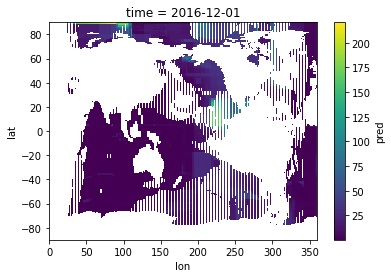

In [28]:
p1 = pred_xarray.pred[419].plot()
plt.savefig("../../assets/mpi_rf_pred_socat.jpg")

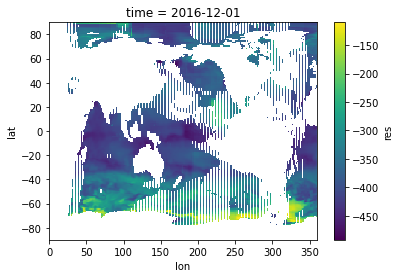

In [29]:
res_xarray.res[419].plot()
plt.savefig("../../assets/mpi_rf_res_socat.jpg")

/tmp/ipykernel_1165224/2119154728.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_df['time'] = pd.to_datetime(true_df['time'])


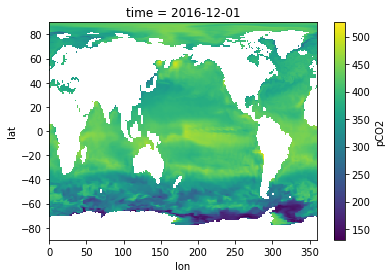

In [30]:
col_names = ["time","lon","lat","pCO2"]
true_df = new_df[["time","xlon","ylat","pCO2"]]
true_df.columns = col_names
true_df['time'] = pd.to_datetime(true_df['time'])
true_df = true_df.set_index(["time","lat","lon"])


true_xarray = true_df.to_xarray()

true_xarray.pCO2[419].plot()